# Base Imports

In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pickle

from limlam_mocker import limlam_mocker as llm
#Get Parameters for run
from limlam_mocker import params        as params

import lnn as lnn

%load_ext autoreload

In [2]:
%autoreload
# %autoreload 0
#%autoreload 2

# Setup Learning Environment

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
mapLoc = '../maps2/test/'
catLoc = '../catalogues2/'
modelLoc = '../models2/'

In [5]:
### map info
numb_maps = 100
pix_x = 256
pix_y = 256

### output info
lum_func_size = 49

# Set Up the Model

In [6]:
model = keras.Sequential()
### convolutional layer
model.add(keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=(pix_x, pix_y, numb_maps)))
### pooling layer
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
### convolutional layer
model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
### pooling layer
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
### flatten the network
model.add(keras.layers.Flatten())
### make a dense layer for the second to last step
model.add(keras.layers.Dense(1000, activation='relu'))
### finish it off with a dense layer with the number of output we want for our luminosity function
model.add(keras.layers.Dense(lum_func_size, activation='linear'))

In [7]:
model.compile(loss=keras.losses.logcosh, 
              optimizer=keras.optimizers.SGD(), 
              metrics=[keras.metrics.mse])

# Model 2

In [8]:
model2 = keras.Sequential()
### convolutional layer
model2.add(keras.layers.Conv3D(32, kernel_size=(5,5,5), strides=(1,1,1), activation='relu', input_shape=(pix_x, pix_y, numb_maps, 1)))
### use a convolution instead of a pool that acts like a pool
model2.add(keras.layers.Conv3D(32, kernel_size=(2,2,2), strides=(2,2,2), activation='relu'))
### convolutional layer
model2.add(keras.layers.Conv3D(64, (5,5,5), activation='relu'))
### use a convolution instead of a pool that acts like a pool
model2.add(keras.layers.Conv3D(64, kernel_size=(2,2,2), strides=(2,2,2), activation='relu'))
### flatten the network
model2.add(keras.layers.Flatten())
### make a dense layer for the second to last step
model2.add(keras.layers.Dense(1000, activation='relu'))
### finish it off with a dense layer with the number of output we want for our luminosity function
model2.add(keras.layers.Dense(lum_func_size, activation='linear'))

In [9]:
model2.compile(loss=keras.losses.logcosh, 
              optimizer=keras.optimizers.SGD(), 
              metrics=[keras.metrics.mse])

# Load Model

In [31]:
model2 = keras.models.load_model(modelLoc + 'my_model_gpu_2.hdf5')

In [32]:
model2.layers

In [8]:
model2 = keras.models.load_model(modelLoc + 'my_model_gpu_2_temp.hdf5')

In [9]:
model2.layers

In [60]:
model2 = keras.models.load_model(modelLoc + 'my_model_full_lum_gpu.hdf5')

In [61]:
with open(modelLoc + 'my_model_full_lum_gpu_history', 'rb') as pickle_file:
    history = pickle.load(pickle_file)

In [62]:
model2.layers

In [76]:
model_5_layer = keras.models.load_model(modelLoc + 'my_model_full_lum_gpu_5_layer_temp.hdf5')
model_5_layer.layers

In [77]:
model_5_layer.layers[9].input

<tf.Tensor 'conv3d_4_1/Relu:0' shape=(?, 8, 8, 2, 512) dtype=float32>

# Start Training the Network

In [10]:
### number of maps to look at in a batch
batch_size = 100
steps_per_epoch = 5
epochs = 10

subFields = lnn.loadBaseFNames(mapLoc)
base = [mapLoc + s for s in subFields]

dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(base))
dataset = dataset.shuffle(buffer_size=len(base))
dataset = dataset.map(lambda item: tuple(tf.py_func(lnn.utf8FileToMapAndLum, [item], [tf.float64, tf.float64])))
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)

In [16]:
model.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Epoch 1/10
5/5 [==============================] - 432s 86s/step - loss: 4.2342 - mean_squared_error: 26.3019
Epoch 2/10
5/5 [==============================] - 434s 87s/step - loss: 4.2319 - mean_squared_error: 26.2792
Epoch 3/10
5/5 [==============================] - 442s 88s/step - loss: 4.2325 - mean_squared_error: 26.2876
Epoch 4/10
5/5 [==============================] - 440s 88s/step - loss: 4.2305 - mean_squared_error: 26.2651
Epoch 5/10
5/5 [==============================] - 441s 88s/step - loss: 4.2284 - mean_squared_error: 26.2510
Epoch 6/10
5/5 [==============================] - 435s 87s/step - loss: 4.2267 - mean_squared_error: 26.2265
Epoch 7/10
5/5 [==============================] - 448s 90s/step - loss: 4.2258 - mean_squared_error: 26.2198
Epoch 8/10
5/5 [==============================] - 445s 89s/step - loss: 4.2249 - mean_squared_error: 26.2079
Epoch 9/10
5/5 [==============================] - 443s 89s/step - loss: 4.2232 - mean_squared_error: 26.1965
Epoch 10/10
5/5 [==

In [27]:
model.save('my_model.h5')

In [32]:
### number of maps to look at in a batch
batch_size = 1
steps_per_epoch = 1
epochs = 1

subFields = lnn.loadBaseFNames(mapLoc)
base = [mapLoc + s for s in subFields]

dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(base))
dataset = dataset.shuffle(buffer_size=len(base))
dataset = dataset.map(lambda item: tuple(tf.py_func(lnn.utf8FileToMapAndLum3D, [item], [tf.float64, tf.float64])))
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)

In [34]:
history = model2.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Epoch 1/1
1/1 [==============================] - 68s 68s/step - loss: 0.0065 - mean_squared_error: 0.0131


In [15]:
model2.save('my_model2.h5')

In [14]:
model2.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Epoch 1/5
5/5 [==============================] - 1790s 358s/step - loss: 4.0312 - mean_squared_error: 24.3023
Epoch 2/5
5/5 [==============================] - 1811s 362s/step - loss: 2.9661 - mean_squared_error: 17.2210
Epoch 3/5
5/5 [==============================] - 1868s 374s/step - loss: 3.2975 - mean_squared_error: 19.5987
Epoch 4/5
5/5 [==============================] - 1812s 362s/step - loss: 1.8060 - mean_squared_error: 8.0837
Epoch 5/5
5/5 [==============================] - 1802s 360s/step - loss: 1.6294 - mean_squared_error: 6.6302


# See How Good the Model Is

In [8]:
subFields = lnn.loadBaseFNames(mapLoc)
base = [mapLoc + s for s in subFields]
lumLogBinCents = lnn.loadData(base[152] + '_lum.npz')['logBinCent']

In [14]:
testMap = lnn.fileToMapData(base[152] + '_map.npz')
testLum = lnn.logLumFunc(lnn.fileToLum(base[152] + '_lum.npz'))
baseMap2 = np.expand_dims(testMap, axis=0)
baseLum2 = np.expand_dims(testLum, axis=0)

newLum = model2.predict(tf.convert_to_tensor(baseMap2), steps=1)
model2.evaluate(tf.convert_to_tensor(baseMap2), tf.convert_to_tensor(baseLum2), steps=1, verbose=1)

ValueError: Error when checking input: expected conv3d_input to have 5 dimensions, but got array with shape (1, 256, 256, 100)

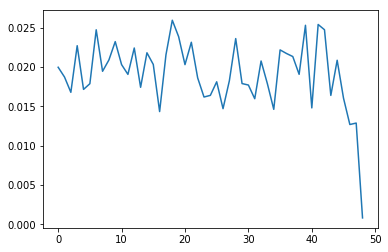

In [36]:
plt.plot(newLum[0])

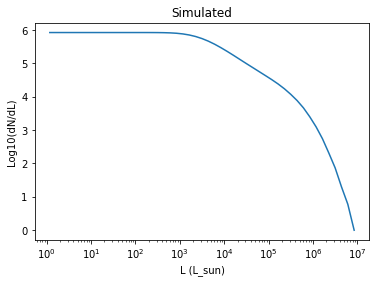

In [39]:
plt.semilogx(lumLogBinCents, testLum)
plt.title('Simulated')
plt.xlabel('L (L_sun)')
plt.ylabel('Log10(dN/dL)')

In [50]:
'testMap = lnn.fileToMapData(base[750] + '_map.npz')
testLum = lnn.logLumFunc(lnn.fileToLum(base[750] + '_lum.npz'))

testMap = testMap.reshape(len(testMap), len(testMap[0]), len(testMap[0][0]), 1)

baseMap2 = np.expand_dims(testMap, axis=0)
# baseMap2 = np.expand_dims(baseMap2, axis=0)
baseLum2 = np.expand_dims(testLum, axis=0)

newLum = model2.predict(tf.convert_to_tensor(baseMap2), steps=1)
model2.evaluate(tf.convert_to_tensor(baseMap2), tf.convert_to_tensor(baseLum2), steps=1, verbose=1)'

1/1 [==============================] - 2s 2s/step


[0.0049522821791470051, 0.010024302639067173]

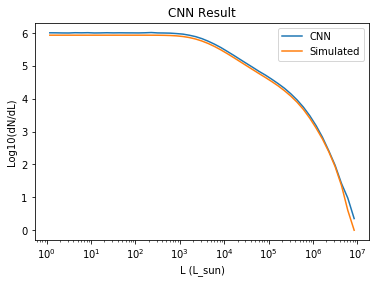

In [51]:
plt.semilogx(lumLogBinCents, newLum[0], label='CNN')
plt.semilogx(lumLogBinCents, testLum, label='Simulated')
plt.legend()
plt.title('CNN Result')
plt.xlabel('L (L_sun)')
plt.ylabel('Log10(dN/dL)')

/home/dpfeffe2/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(1, 10000000)

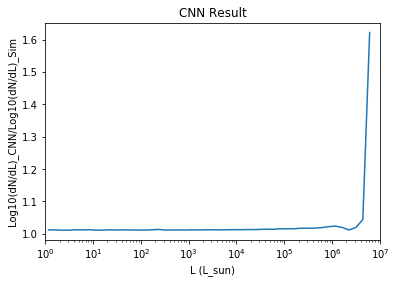

In [52]:
plt.semilogx(lumLogBinCents, newLum[0]/testLum)
plt.title('CNN Result')
plt.xlabel('L (L_sun)')
plt.ylabel('Log10(dN/dL)_CNN/Log10(dN/dL)_Sim')
plt.xlim([1, 10**7])
# plt.ylim([0.98, 1.05])

/home/dpfeffe2/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(0.98, 1.03)

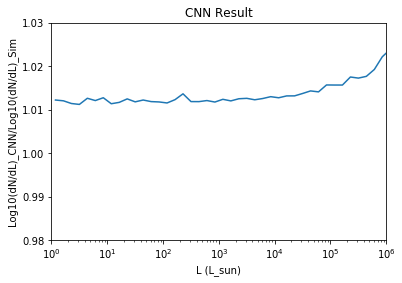

In [57]:
plt.semilogx(lumLogBinCents, newLum[0]/testLum)
plt.title('CNN Result')
plt.xlabel('L (L_sun)')
plt.ylabel('Log10(dN/dL)_CNN/Log10(dN/dL)_Sim')
plt.xlim([1, 10**6])
plt.ylim([0.98, 1.03])

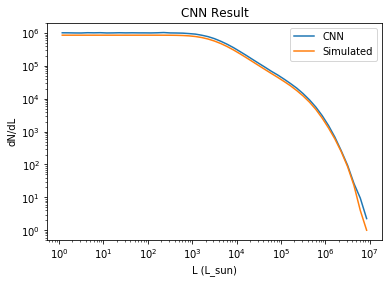

In [53]:
cnnLum = np.array([10**x for x in newLum[0]])
realLum = np.array([10**x for x in testLum])

plt.loglog(lumLogBinCents, cnnLum, label='CNN')
plt.loglog(lumLogBinCents, realLum, label='Simulated')
plt.legend()
plt.title('CNN Result')
plt.xlabel('L (L_sun)')
plt.ylabel('dN/dL')

(1, 10000000)

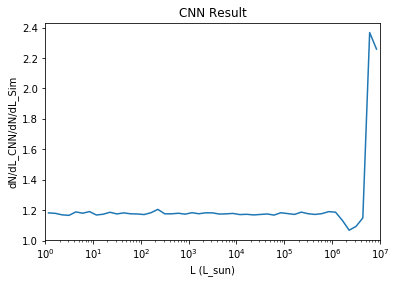

In [54]:
plt.semilogx(lumLogBinCents, cnnLum/realLum)
plt.title('CNN Result')
plt.xlabel('L (L_sun)')
plt.ylabel('dN/dL_CNN/dN/dL_Sim')
plt.xlim([1, 10**7])
# plt.ylim([0.90, 1.10])

(0.9, 1.3)

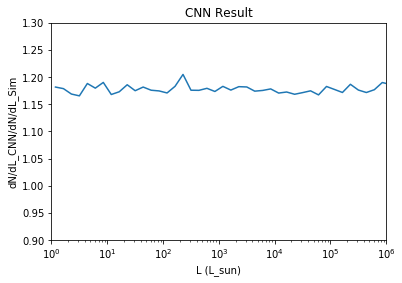

In [59]:
plt.semilogx(lumLogBinCents, cnnLum/realLum)
plt.title('CNN Result')
plt.xlabel('L (L_sun)')
plt.ylabel('dN/dL_CNN/dN/dL_Sim')
plt.xlim([1, 10**6])
plt.ylim([0.90, 1.3])

In [37]:
testMap = lnn.fileToMapData(base[753] + '_map.npz')
testLum = lnn.logLumFunc(lnn.fileToLum(base[753] + '_lum.npz'))

testMap = testMap.reshape(len(testMap), len(testMap[0]), len(testMap[0][0]), 1)

baseMap2 = np.expand_dims(testMap, axis=0)
# baseMap2 = np.expand_dims(baseMap2, axis=0)
baseLum2 = np.expand_dims(testLum, axis=0)

newLum = model2.predict(tf.convert_to_tensor(baseMap2), steps=1)
model2.evaluate(tf.convert_to_tensor(baseMap2), tf.convert_to_tensor(baseLum2), steps=1, verbose=1)

1/1 [==============================] - 7s 7s/step


[0.57242500782012939, 1.423541784286499]

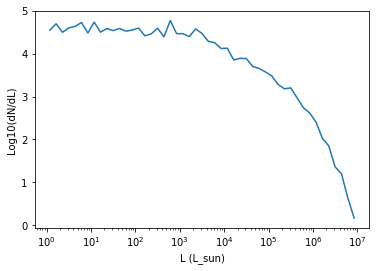

In [38]:
plt.semilogx(lumLogBinCents, newLum[0])
plt.xlabel('L (L_sun)')
plt.ylabel('Log10(dN/dL)')

# Test CNN of full lum func

In [63]:
subFields = lnn.loadBaseFNames(mapLoc)
base = [mapLoc + s for s in subFields]
lumLogBinCents = lnn.loadData(base[750] + '_lum.npz')['logBinCent']

In [64]:
testMap = lnn.fileToMapData(base[750] + '_map.npz')
testLum = lnn.justLumFunc(lnn.fileToLum(base[750] + '_lum.npz'))

testMap = testMap.reshape(len(testMap), len(testMap[0]), len(testMap[0][0]), 1)

baseMap2 = np.expand_dims(testMap, axis=0)
# baseMap2 = np.expand_dims(baseMap2, axis=0)
baseLum2 = np.expand_dims(testLum, axis=0)

newLum = model2.predict(tf.convert_to_tensor(baseMap2), steps=1)
model2.evaluate(tf.convert_to_tensor(baseMap2), tf.convert_to_tensor(baseLum2), steps=1, verbose=1)

1/1 [==============================] - 2s 2s/step


[8.7718696594238281, 324348280832.0]

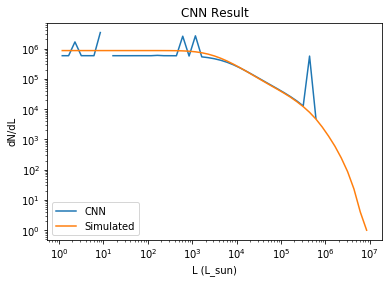

In [65]:
plt.loglog(lumLogBinCents, newLum[0], label='CNN')
plt.loglog(lumLogBinCents, testLum, label='Simulated')
plt.legend()
plt.title('CNN Result')
plt.xlabel('L (L_sun)')
plt.ylabel('dN/dL')

(0, 75)

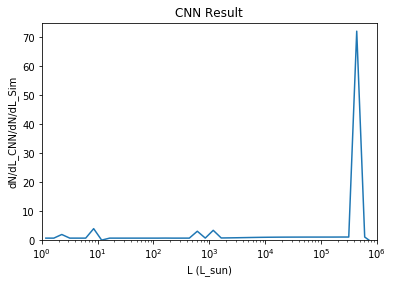

In [75]:
plt.semilogx(lumLogBinCents, newLum[0]/testLum)
plt.title('CNN Result')
plt.xlabel('L (L_sun)')
plt.ylabel('dN/dL_CNN/dN/dL_Sim')
plt.xlim([1, 10**6])
plt.ylim([0, 75])

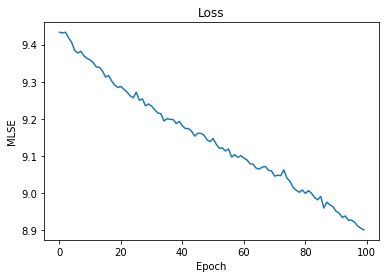

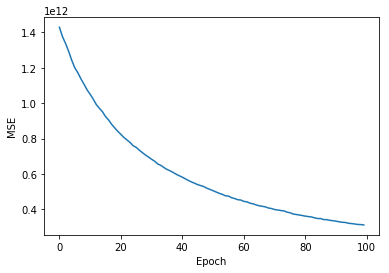

In [66]:
plt.plot(range(100), history['loss'])
plt.xlabel('Epoch')
plt.ylabel('MLSE')
plt.title('Loss')
plt.show()
plt.plot(range(100), history['mean_squared_error'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [78]:
testMap = lnn.fileToMapData(base[750] + '_map.npz')
testLum = lnn.justLumFunc(lnn.fileToLum(base[750] + '_lum.npz'))

testMap = testMap.reshape(len(testMap), len(testMap[0]), len(testMap[0][0]), 1)

baseMap2 = np.expand_dims(testMap, axis=0)
# baseMap2 = np.expand_dims(baseMap2, axis=0)
baseLum2 = np.expand_dims(testLum, axis=0)

newLum = model_5_layer.predict(tf.convert_to_tensor(baseMap2), steps=1)
model_5_layer.evaluate(tf.convert_to_tensor(baseMap2), tf.convert_to_tensor(baseLum2), steps=1, verbose=1)

1/1 [==============================] - 2s 2s/step


[24.525211334228516, 12289769996288.0]

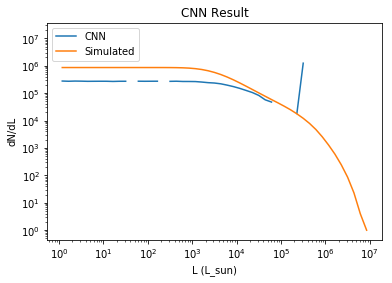

In [79]:
plt.loglog(lumLogBinCents, newLum[0], label='CNN')
plt.loglog(lumLogBinCents, testLum, label='Simulated')
plt.legend()
plt.title('CNN Result')
plt.xlabel('L (L_sun)')
plt.ylabel('dN/dL')

# Test Making Dataset for training

In [24]:
loc = '../maps/test/'
base = lnn.loadBaseFNames(loc)

In [25]:
base[0]

'COMAP_z2.39-3.44_1140Mpc_seed_13659_rotate_0_subfield_35'

In [26]:
mapData, lumData = lnn.fileToMapAndLum(loc + base[0])

In [28]:
mapData[0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         5.44276602,  0.44655489],
       [ 0.        ,  2.41778707,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.8976039 ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.8193982 ,
         0.        ,  1.10711577],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [36]:
newMap = mapData.reshape(256, 256, 100, 1)

In [30]:
mapData.size

6553600

In [33]:
len(mapData[0][0])

100

In [41]:
len(newMap[0][0][0])

1

# Visualize learning history

In [31]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 252, 252, 96, 32)  4032      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 126, 126, 48, 32)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 122, 122, 44, 64)  256064    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 61, 61, 22, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 57, 57, 18, 128)   1024128   
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 28, 28, 9, 128)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 24, 24, 5, 256)    4096256   
__________

In [35]:
history.history

{'loss': [0.0064823422580957413], 'mean_squared_error': [0.013114519417285919]}